# Testing environment
## System
|       | Specification |
| :---: | :-----------: |
| Operating System | Debian 12 (Bookworm) |
| Memory | 16.0 Gb |
| Processor | Intel Core i7-8650U |
| Disk | 1 TB Samsung PCIe NVMe SSD |

## Application
| Application | Version |
| :---------: | :-----: |
| Docker | [20.10.24](https://packages.debian.org/source/stable/docker.io) |
| Docker Compose | [1.29.2-3](https://packages.debian.org/source/stable/docker-compose) |
| Python | [3.11.2](https://packages.debian.org/source/stable/python3-defaults) |

The test application uses `pymysql` and `pymongo` and built-in transaction managers.

## Databases
| Database | Version (Docker Image) |
| :------: | :--------------------: |
| MariaDB | 11.5.2 (latest) |
| MongoDB | 24.04 (latest) |
| MySQL | 9.1.0 (latest) |

Databases were run in deafult Docker settings without any fine tuning.

In [53]:
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import pymongo

In [54]:
# Wait for the databases to be ready.
def wait_for_services():
    time.sleep(10)

In [55]:
# MySQL connection.
mysql_conn = pymysql.connect(host="localhost", port=3306, user="root", password="root")
mysql_cursor = mysql_conn.cursor()

In [56]:
# Create the database if it doesn't exist.
mysql_cursor.execute("CREATE DATABASE IF NOT EXISTS test_db;")
mysql_cursor.execute("USE test_db;")

0

In [57]:
# Create MySQL table.
mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS FTIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        FULLTEXT(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS IDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        INDEX(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS NOIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255)
    );
""")

0

In [58]:
# MariaDB connection.
mariadb_conn = pymysql.connect(host='localhost', port=3307, user='root', password='root_password')
mariadb_cursor = mariadb_conn.cursor()

In [59]:
# PostgreSQL connection.
# postgres_conn = pymysql.connect(host='localhost', port=3307, user='root', password='root_password')
# mariadb_cursor = mariadb_conn.cursor()

In [60]:
# Create the database if it doesn't exist.
mariadb_cursor.execute("CREATE DATABASE IF NOT EXISTS test_db;")
mariadb_cursor.execute("USE test_db;")

0

In [61]:
# Create MariaDB table.
mariadb_cursor.execute("""
    CREATE TABLE IF NOT EXISTS FTIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        FULLTEXT(name)
    );
""")

mariadb_cursor.execute("""
    CREATE TABLE IF NOT EXISTS IDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        INDEX(name)
    );
""")

mariadb_cursor.execute("""
    CREATE TABLE IF NOT EXISTS NOIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255)
    );
""")

0

In [62]:
# MongoDB connection.
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["test_db"]

In [63]:
# Create MongoDB collection.
# Full-text index.
FTIDX_collection = mongo_db["FTIDX_collection"]
FTIDX_collection.create_index([("name", pymongo.TEXT)])

# Regular index (in ascending order).
IDX_collection = mongo_db["IDX_collection"]
IDX_collection.create_index([("name", 1)])

# No index, except MongoDB's default index, _id.
NOIDX_collection = mongo_db["NOIDX_collection"]
NOIDX_collection.drop_indexes()

In [64]:
# Insert data into MySQL.
def insert_data_mysql(table, data, transactional=True):
    if transactional:
        mysql_conn.begin() # Start transaction.
    sql = f"INSERT INTO {table} (name, country) VALUES (%s, %s)"
    mysql_cursor.execute(sql, data)
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [65]:
# Insert data into MariaDB.
def insert_data_mariadb(table, data, transactional=True):
    if transactional:
        mariadb_conn.begin() # Start transaction.
    sql = f"INSERT INTO {table} (name, country) VALUES (%s, %s)"
    mariadb_cursor.execute(sql, data)
    if transactional:
        mariadb_conn.commit()  # Commit transaction.

In [66]:
# Insert data into MongoDB.
# In MongoDB, every single document insert is an atomic operation.
def insert_data_mongo(index_type, data, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                if index_type == "FTIDX":
                    FTIDX_collection.insert_one(data)
                elif index_type == "IDX":
                    IDX_collection.insert_one(data)
                else:
                    NOIDX_collection.insert_one(data)
    else:
        if index_type == "FTIDX":
            FTIDX_collection.insert_one(data)
        elif index_type == "IDX":
            IDX_collection.insert_one(data)
        else:
            NOIDX_collection.insert_one(data)

In [67]:
# Update data from MySQL.
def update_data_mysql(table, name, country, transactional=True):
    if transactional:
        mysql_conn.begin()  # Start transaction.
    sql = f"UPDATE {table} SET country = %s WHERE name = %s"
    mysql_cursor.execute(sql, (country, name))
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [68]:
# Update data from MariaDB.
def update_data_mariadb(table, name, country, transactional=True):
    if transactional:
        mariadb_conn.begin()  # Start transaction.
    sql = f"UPDATE {table} SET country = %s WHERE name = %s"
    mariadb_cursor.execute(sql, (country, name))
    if transactional:
        mariadb_conn.commit()  # Commit transaction.

In [69]:
# Update data from MongoDB.
# MongoDB does not have explicit transactions for single operations.
def update_data_mongo(collection, name, country, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                if index_type == "FTIDX":
                    FTIDX_collection.update_one({"name": name}, {"$set": {"country": country}})
                elif index_type == "IDX":
                    IDX_collection.update_one({"name": name}, {"$set": {"country": country}})
                else:
                    NOIDX_collection.update_one({"name": name}, {"$set": {"country": country}})
    else:
        if index_type == "FTIDX":
            FTIDX_collection.update_one({"name": name}, {"$set": {"country": country}})
        elif index_type == "IDX":
            IDX_collection.update_one({"name": name}, {"$set": {"country": country}})
        else:
            NOIDX_collection.update_one({"name": name}, {"$set": {"country": country}})

In [70]:
# Delete data from MySQL.
def delete_data_mysql(table, name, transactional=True):
    if transactional:
        mysql_conn.begin()  # Start transaction.
    sql = f"DELETE FROM {table} WHERE name = %s"
    mysql_cursor.execute(sql, (name,))
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [71]:
# Delete data from MariaDB.
def delete_data_mariadb(table, name, transactional=True):
    if transactional:
        mariadb_conn.begin()  # Start transaction.
    sql = f"DELETE FROM {table} WHERE name = %s"
    mariadb_cursor.execute(sql, (name,))
    if transactional:
        mariadb_conn.commit()  # Commit transaction.

In [72]:
# Delete data from MongoDB.
# MongoDB does not have explicit transactions for single operations.
def delete_data_mongo(collection, name, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                if index_type == "FTIDX":
                    FTIDX_collection.delete_one({"name": name})
                elif index_type == "IDX":
                    IDX_collection.delete_one({"name": name})
                else:
                    NOIDX_collection.delete_one({"name": name})
    else:
        if index_type == "FTIDX":
            FTIDX_collection.delete_one({"name": name})
        elif index_type == "IDX":
            IDX_collection.delete_one({"name": name})
        else:
            NOIDX_collection.delete_one({"name": name})

In [73]:
# Use faker library to generate fake data.
from faker import Faker

fake = Faker()
# id_ = random.randint(1, 10000)
# name = fake.city()
# country = fake.country()
# coord = (str(faker.longitude()), str(faker.latitude()))

# Generate fake sample data.
def create_sample_data(num_records):
    sample_data = []
    for i in range(num_records):
        sample_data.append({
            "id": i,
            "name": f"City_{i}",
            "country": "IN",
            "coord": {"lon": random.uniform(-180, 180), "lat": random.uniform(-90, 90)}
        })
    return sample_data

In [74]:
# Experiment.
# Types of Queries:
#   A. Indexes:
#       1. FTIDX: Full-text indexing for efficient text searches.
#       2. IDX: Regular indexing for general query optimization.
#       3. NOIDX: No indexing, leading to potential performance issues for queries.
#   B. Transactional:
#      1. Transaction
#      2. Non-transaction

results = []
for i in range(100):
    # Generate random data.
    name = f"City_{random.randint(1, 1000)}"
    country = "IN"

    # Insert data with different conditions.
    for index_type in ['FTIDX', 'IDX', 'NOIDX']:
        for transactional in [True, False]:
            # Measure insert time.
            start_time = time.time()
            insert_data_mysql("_".join([index_type, "table"]), (name, country), transactional)
            mysql_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            insert_data_mariadb("_".join([index_type, "table"]), (name, country), transactional)
            mariadb_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            insert_data_mongo(index_type, {"name": name, "country": country}, transactional)
            mongo_duration = (time.time() - start_time) * 1000

            # Measure update time.
            country = fake.country()
            start_time = time.time()
            update_data_mysql("_".join([index_type, "table"]), name, country, transactional)
            mysql_update_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            update_data_mariadb("_".join([index_type, "table"]), name, country, transactional)
            mariadb_update_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            update_data_mongo(index_type, name, country, transactional)
            mongo_update_duration = (time.time() - start_time) * 1000

            # Measure delete time.
            start_time = time.time()
            delete_data_mysql("_".join([index_type, "table"]), name, transactional)
            mysql_delete_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            delete_data_mariadb("_".join([index_type, "table"]), name, transactional)
            mariadb_delete_duration = (time.time() - start_time) * 1000

            start_time = time.time()
            delete_data_mongo(index_type, name, transactional)
            mongo_delete_duration = (time.time() - start_time) * 1000

            # Store results.
            results.append({
                "Index Type": index_type,
                "Transaction": "TX" if transactional else "NOTX",
                "MySQL Insert Time (ms)": mysql_duration,
                "MariaDB Insert Time (ms)": mariadb_duration,
                "MongoDB Insert Time (ms)": mongo_duration,
                "MySQL Update Time (ms)": mysql_update_duration,
                "MariaDB Update Time (ms)": mariadb_update_duration,
                "MongoDB Update Time (ms)": mongo_update_duration,
                "MySQL Delete Time (ms)": mysql_delete_duration,
                "MariaDB Delete Time (ms)": mariadb_delete_duration,
                "MongoDB Delete Time (ms)": mongo_delete_duration
            })

In [75]:
# Convert results to Pandas' DataFrame.
results_df = pd.DataFrame(results)
results_df.head

<bound method NDFrame.head of     Index Type Transaction  MySQL Insert Time (ms)  MariaDB Insert Time (ms)  \
0        FTIDX          TX               17.000675                  7.822752   
1        FTIDX        NOTX                0.635386                  0.614166   
2          IDX          TX               27.733326                  7.763147   
3          IDX        NOTX                1.527071                  1.308441   
4        NOIDX          TX               23.589611                  7.992506   
..         ...         ...                     ...                       ...   
595      FTIDX        NOTX                1.525402                  1.173258   
596        IDX          TX               24.549484                  6.311655   
597        IDX        NOTX                1.495361                  1.041889   
598      NOIDX          TX               19.032955                  5.945444   
599      NOIDX        NOTX                1.318932                  1.029015   

     Mong

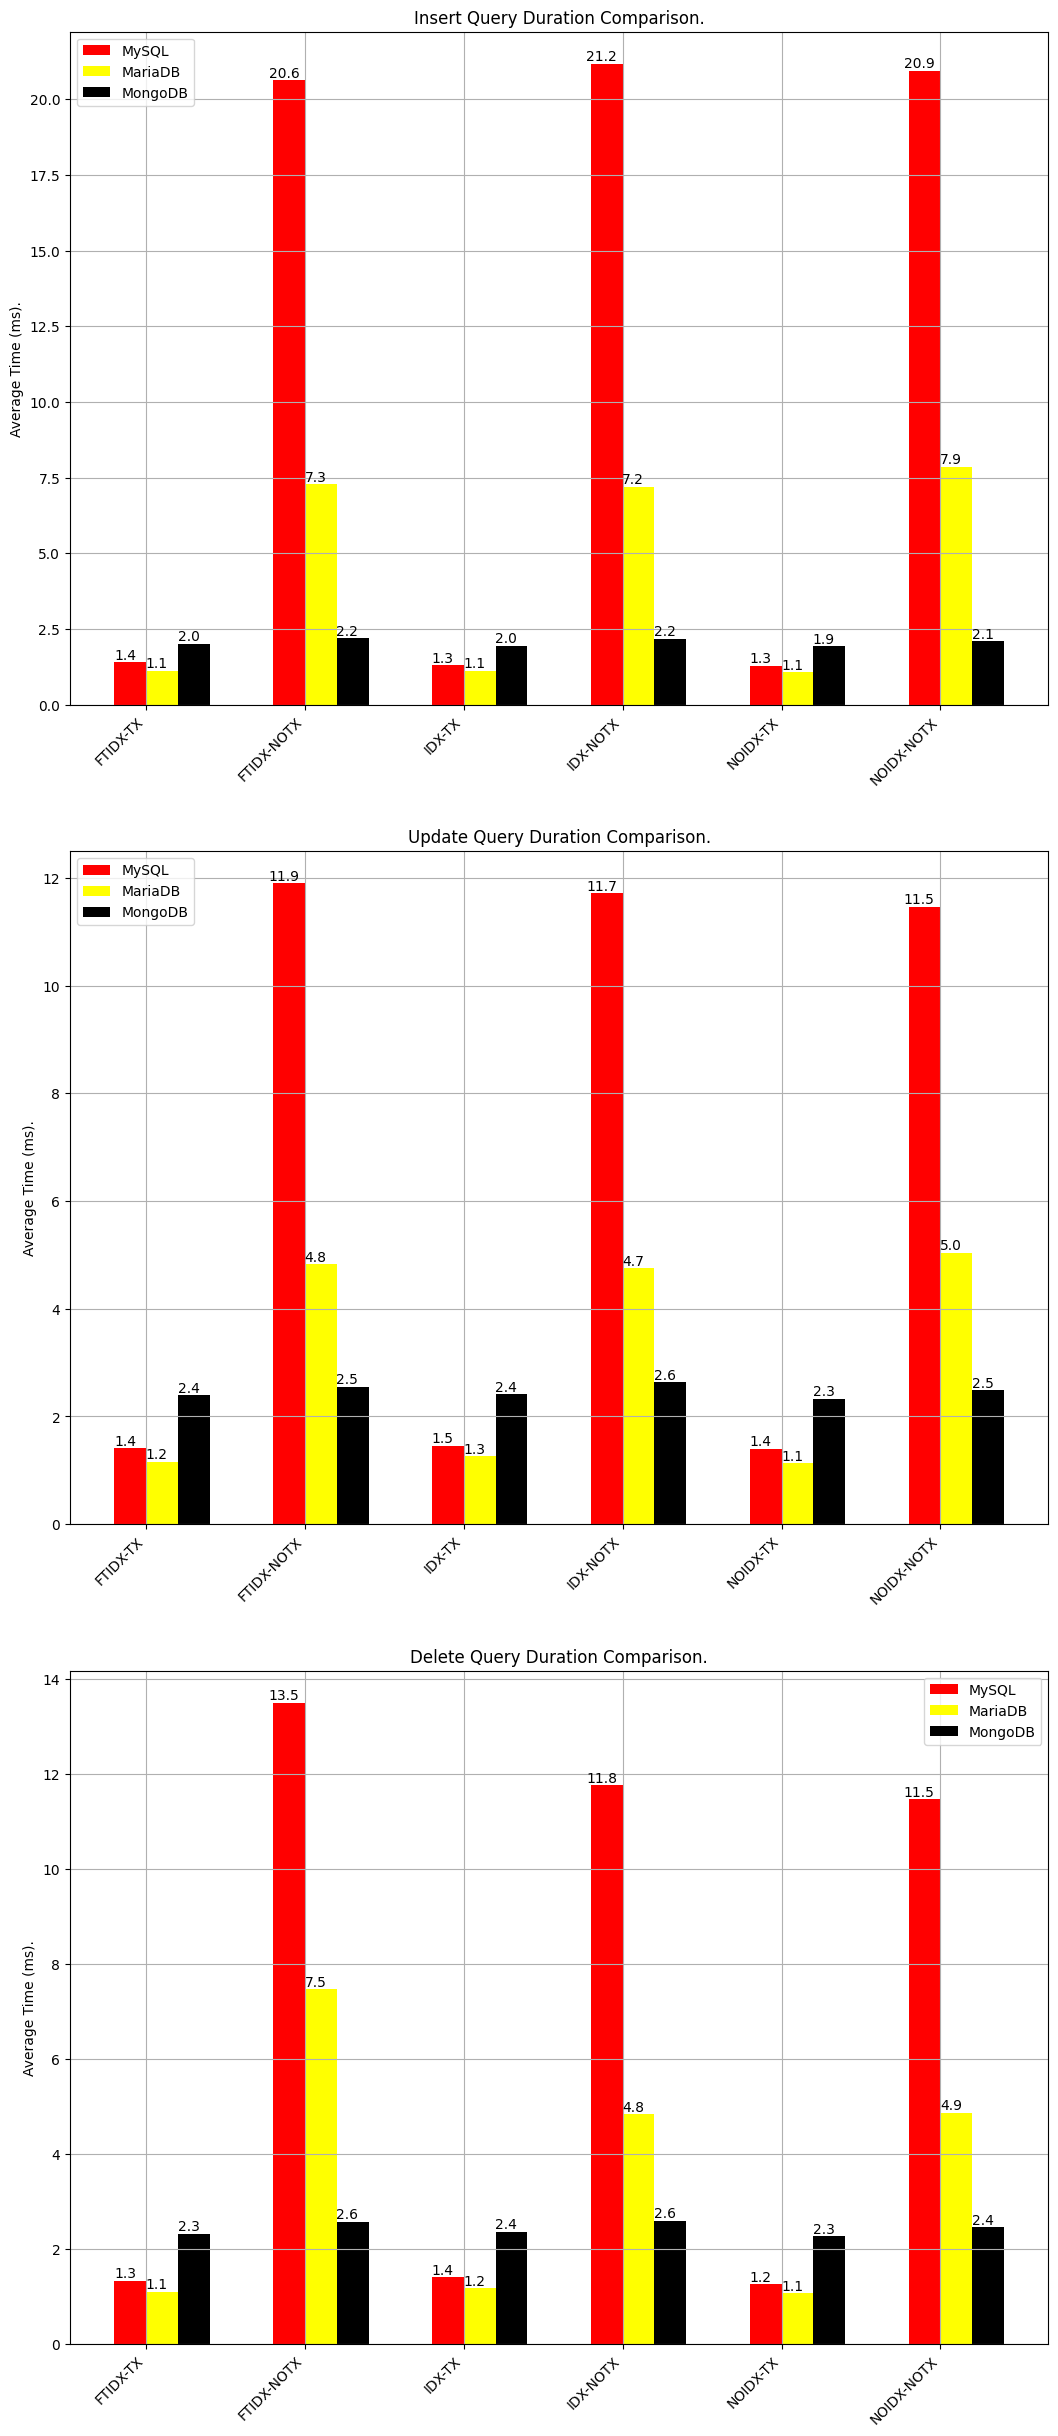

In [82]:
# Create a new column for combined labels.
results_df['Label'] = results_df['Index Type'] + '-' + results_df['Transaction']

# Set the bar width.
bar_width = 0.2

# Create subplots for each query type, increase the figure size to avoid overlap.
fig, axs = plt.subplots(3, 1, figsize=(12, 25))

# Define query types and their corresponding column names.
query_types = ['Insert', 'Update', 'Delete']
mysql_columns = ['MySQL Insert Time (ms)', 'MySQL Update Time (ms)', 'MySQL Delete Time (ms)']
mariadb_columns = ['MariaDB Insert Time (ms)', 'MariaDB Update Time (ms)', 'MariaDB Delete Time (ms)']
mongo_columns = ['MongoDB Insert Time (ms)', 'MongoDB Update Time (ms)', 'MongoDB Delete Time (ms)']

# Loop through each query type and create a bar plot.
for i, query in enumerate(query_types):
    # Set the positions of the bars on the x-axis.
    x = np.arange(len(results_df['Label'].unique()))
    
    # Plot MySQL and MongoDB times for the current query type.
    mysql_heights = results_df.groupby('Label')[mysql_columns[i]].mean()
    mariadb_heights = results_df.groupby('Label')[mariadb_columns[i]].mean()
    mongo_heights = results_df.groupby('Label')[mongo_columns[i]].mean()
    
    # Plot the bars.
    bars_mysql = axs[i].bar(x - bar_width/2,
                            mysql_heights,
                            width=bar_width,
                            label='MySQL', color='red')

    bars_mariadb = axs[i].bar(x + bar_width/2,
                        mariadb_heights,
                        width=bar_width,
                        label='MariaDB', color='yellow')
    
    bars_mongo = axs[i].bar(x + 1.5 * bar_width, 
                            mongo_heights, 
                            width=bar_width, 
                            label='MongoDB', color='black')

    # Add value labels on top of each bar.
    for bars, heights in zip([bars_mysql, bars_mariadb, bars_mongo], [mysql_heights, mariadb_heights, mongo_heights]):
        for bar, height in zip(bars, heights):
            axs[i].text(bar.get_x() + bar.get_width() / 3, height, 
                        f'{height:.1f}',
                        ha='center', va='bottom', fontsize=10, color='black')

    # Set the x-ticks and labels.
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(results_df['Label'].unique(), rotation=45, ha="right")
    axs[i].set_title(f'{query} Query Duration Comparison.')
    axs[i].set_ylabel('Average Time (ms).')
    axs[i].legend()
    axs[i].grid()

# Adjust layout to prevent label overlap and add more space to the right.
plt.tight_layout(pad=3.0)
plt.subplots_adjust(right=0.9)

# Show the plot.
plt.show()

In [ ]:
# Close connections.
mysql_cursor.close()
mysql_conn.close()
mariadb_cursor.close()
mariadb_conn.close()
mongo_client.close()